In [38]:
import pandas as pd
import fiftyone as fo

import seaborn as sns

custom_params = {"axes.facecolor": ".96"}
sns.set_theme(style="darkgrid", rc=custom_params, palette='mako')
# sns.set_theme(style="darkgrid", palette='mako')
# sns.set_theme(style='darkgrid',{"grid.color": ".6"}, palette='mako')

## Label distribution in ROV dataset

In [2]:
def make_df(dataset, splits):
    """Counts how many annotations of each label exist per split.

    Args:
        dataset (fiftyone dataset): Fiftyone dataset.
        splits (list): List of splits in the fiftyone dataset. E.g.: ['train', 'test']

    Returns:
        pandas DataFrame: label, count and split columns.
    """    
    df_list = []
    for i in splits:
        view = dataset.match_tags(i)
        count_dict = view.count_values("ground_truth.detections.label")

        df = pd.DataFrame(count_dict.items(), columns=['label', 'count']).copy()
        df["split"] = i
        df_list.append(df)
    
    return pd.concat(df_list)

In [3]:
rov_dataset = fo.load_dataset("rov")

In [4]:
label_count = make_df(rov_dataset, ["train", "val", "test"])
label_count.head()

# save label counts
# label_count.to_csv("../results/label_count_split.csv", index=False)

,label,count,split
0,Other,35,train
1,Poeobius meseres,856,train
2,Equipment,23,train
3,Anemone,22,train
4,Echinoderm,553,train


/tmp/ipykernel_3146/1711040779.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  label_dist.set_xticklabels(label_dist.get_xticklabels(), rotation=45, horizontalalignment='right');


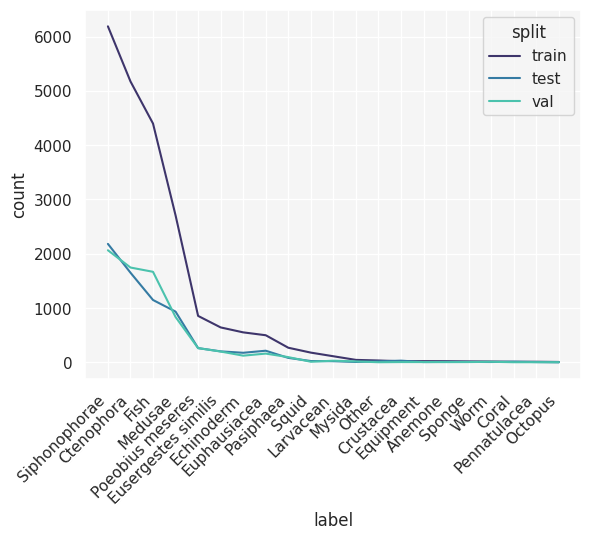

In [39]:
# sort by count, more labels first
sorted_df = label_count.sort_values(by='count', ascending=False)

# plot label counts
label_dist = sns.lineplot(data=sorted_df, x="label", y="count", hue="split", palette="mako")
label_dist.set_xticklabels(label_dist.get_xticklabels(), rotation=45, horizontalalignment='right');

/tmp/ipykernel_3146/2062085284.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  label_dist.set_xticklabels(label_dist.get_xticklabels(), rotation=45, horizontalalignment='right');


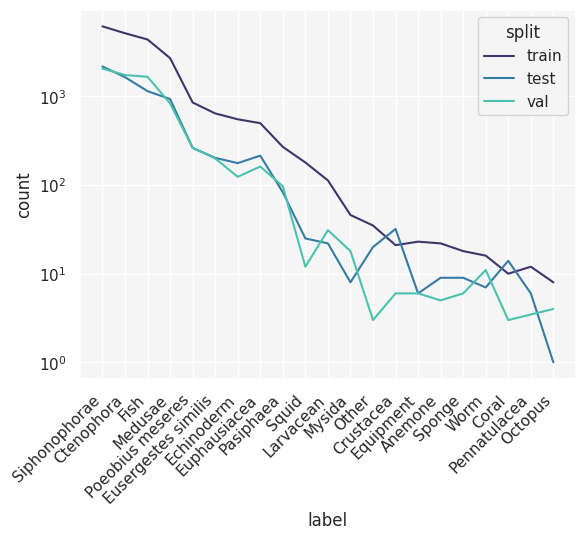

In [6]:
# plot label counts
label_dist = sns.lineplot(data=sorted_df, x="label", y="count", hue="split", palette="mako")
label_dist.set_xticklabels(label_dist.get_xticklabels(), rotation=45, horizontalalignment='right');
label_dist.set_yscale('log')

## ROV model performance comparison per class

In [7]:
acc_class = pd.read_csv("../artifacts/results/results_by_class.csv")

In [8]:
acc_class_noall = acc_class[acc_class['class'] != "all"]
acc_class_noall

,model,class,image_count,instance_count,precision,recall,map50,map50_95
1,yolov8n_16_640,Pasiphaea,4747,97,0.841,0.629,0.75100,0.50300
2,yolov8n_16_640,Poeobius meseres,4747,263,0.669,0.607,0.67300,0.41500
3,yolov8n_16_640,Siphonophorae,4747,2062,0.719,0.790,0.79900,0.58700
4,yolov8n_16_640,Ctenophora,4747,1746,0.875,0.820,0.88500,0.72900
5,yolov8n_16_640,Medusae,4747,834,0.834,0.860,0.88800,0.74800
...,...,...,...,...,...,...,...,...
79,yolov8l_8_1280,Anemone,4747,5,0.287,0.200,0.21400,0.08790
80,yolov8l_8_1280,Equipment,4747,6,1.000,0.000,0.00593,0.00153
81,yolov8l_8_1280,Coral,4747,3,1.000,0.000,0.01200,0.00719
82,yolov8l_8_1280,Sponge,4747,6,0.653,0.333,0.40800,0.32100


In [9]:
# over_100 = acc_class_noall[acc_class_noall['instance_count'] > 100]
# under_100 = acc_class_noall[acc_class_noall['instance_count'] < 100]

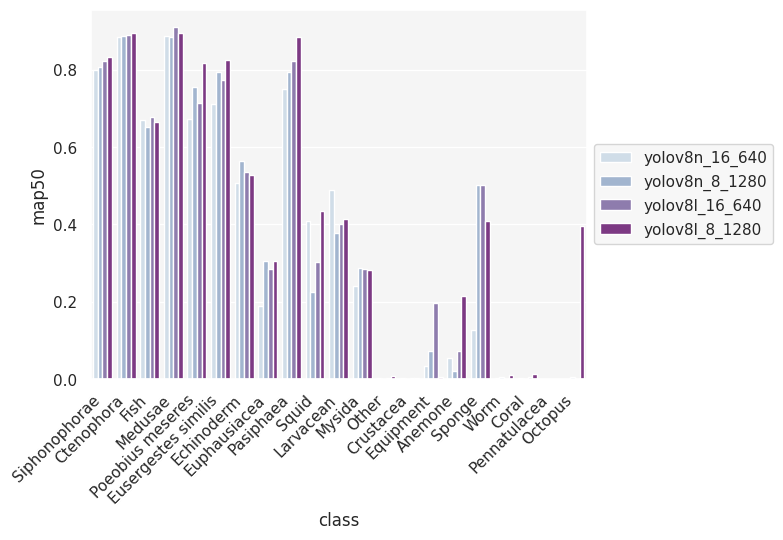

In [40]:
class_order = list(sorted_df.label.unique())
# hue_order = list(acc_class_noall.model.unique())
# hue_order.reverse()

# map50_rov = sns.stripplot(data=acc_class_noall, x="class", y="map50", 
#                             hue="model", 
#                             # hue_order=hue_order,
#                             palette='BuPu', 
#                             order=class_order,
#                             jitter=False
#                             )

map50_rov = sns.barplot(data=acc_class_noall, x="class", y="map50", 
                            hue="model", 
                            # hue_order=hue_order,
                            palette='BuPu', 
                            order=class_order,
                            )
map50_rov.set_xticklabels(map50_rov.get_xticklabels(), rotation=45, horizontalalignment='right')
map50_rov.legend(loc='center left', bbox_to_anchor=(1, .5));
# map50_rov.set_yscale('log')

### Eusergestis per model

In [ ]:
just_shrimp = acc_class[acc_class['class'] == "Eusergestes similis"]

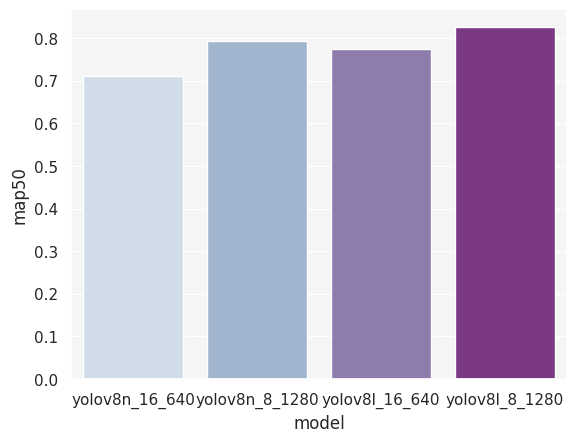

In [41]:
shrimp_rov = sns.barplot(data=just_shrimp, x="model", y="map50", 
                            # hue="model", 
                            # hue_order=hue_order,
                            palette='BuPu', 
                            )


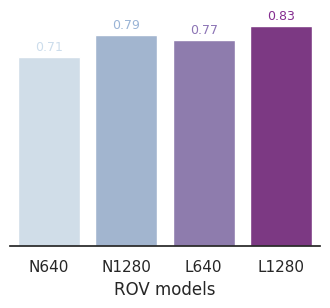

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

with sns.axes_style(style='white', rc={"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False}):
    plt.figure(figsize=(4, 3))
    shrimp_rov = sns.barplot(data=just_shrimp, x="model", y="map50", palette='BuPu')
    shrimp_rov.set_xticklabels(['N640', 'N1280', 'L640', 'L1280'])

    # Remove y-axis label and yticklabels
    shrimp_rov.set(ylabel='', yticklabels=[], xlabel='ROV models')

    # Get color information and iterate through bars
    palette = sns.color_palette('BuPu', n_colors=len(just_shrimp["model"].unique()))
    color_mapping = dict(zip(just_shrimp["model"].unique(), palette))

    for i, bar in enumerate(shrimp_rov.containers[0]):
        model_name = just_shrimp["model"].unique()[i]
        text_color = color_mapping[model_name]
        shrimp_rov.annotate(
            f"{bar.get_height():.2f}",
            (bar.get_x() + bar.get_width() / 2, bar.get_height()),
            ha="center",
            va="bottom",
            fontsize=9,
            color=text_color,
            xytext=(0, 3),
            textcoords="offset points",
        )

    # Show the plot
    plt.show()

## AUV models evaluation

In [ ]:
auv_results = pd.read_csv('../artifacts/results/auv_results.csv')

In [ ]:
auv_results.columns

In [ ]:
sns.lmplot(y='metrics/mAP50(B)', x='auv_train_sample_count', data=auv_results, fit_reg=True);

In [ ]:
sns.lmplot(y='metrics/mAP50(B)', x='auv_train_sample_count', data=auv_results, fit_reg=True, order=6, ci=None);

In [ ]:
exclude = auv_results[auv_results['auv_train_sample_count'] > 49]
sns.lmplot(y='metrics/mAP50(B)', x='auv_train_sample_count', data=exclude, fit_reg=True);

## Uniqueness vs mAP50 vs sample count

In [ ]:
# code used to generate this analysis

# import re

# my_list = list(auv_dataset.count_sample_tags())
# regex = re.compile(r"train\d+")

# result = list(filter(regex.search, my_list))
# print(result)

# sample_tags = result

# auv_dataset = fo.load_dataset("auv")

# for i in sample_tags:
#     mean = auv_dataset.match_tags(i).mean("uniqueness")
#     std = auv_dataset.match_tags(i).std("uniqueness")
#     # quantiles = auv_dataset.match_tags(i).quantiles("uniqueness", [0.25, 0.5, 0.75, 0.9])

#     print(f"{i} {mean} {std}")

In [ ]:
uniq = pd.read_csv('/mnt/c/Users/sabri/Documents/github/thesis/artifacts/results/uniq_increasing_random.csv', index_col=0)

In [ ]:
uniq

Only measures linear correlation.

- The correlation coefficient ranges from −1 to 1. An absolute value of exactly 1 implies that a linear equation describes the relationship between X and Y perfectly, with all data points lying on a line. 
- The correlation sign is determined by the regression slope: a value of +1 implies that all data points lie on a line for which Y increases as X increases, and vice versa for −1.
- A value of 0 implies that there is no linear dependency between the variables.

In [ ]:
uniq.corr("pearson")

Intuitively, the Kendall correlation between two variables will be high when observations have a similar (or identical for a correlation of 1) rank (i.e. relative position label of the observations within the variable: 1st, 2nd, 3rd, etc.) between the two variables, and low when observations have a dissimilar (or fully different for a correlation of −1) rank between the two variables.

The Kendall rank coefficient is often used as a test statistic in a statistical hypothesis test to establish whether two variables may be regarded as statistically dependent. This test is non-parametric, as it does not rely on any assumptions on the distributions of X or Y or the distribution of (X,Y).

In [ ]:
uniq.corr("kendall")

How well the distribution follows a monotonic function.

If there are no repeated data values, a perfect Spearman correlation of +1 or −1 occurs when each of the variables is a perfect monotone function of the other.

In [ ]:
uniq.corr("spearman")

In [ ]:
uniq.plot.scatter(x='uniqueness_std', y='eusergestes_mAP50', c='sample_count', colormap='mako_r');

In [ ]:
uniq.plot.scatter(y='uniqueness_std', x='sample_count', c='sample_count', colormap='mako_r');

In [ ]:
uniq.plot.scatter(y='eusergestes_mAP50', x='sample_count', c='sample_count', colormap='mako_r');


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is called 'uniq'

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Plot the scatter plots in their respective subplots
uniq.plot.scatter(y='uniqueness_std', x='eusergestes_mAP50', c='sample_count', colormap='mako_r', ax=axes[2])
uniq.plot.scatter(x='uniqueness_std', y='sample_count', c='sample_count', colormap='mako_r', ax=axes[0])
uniq.plot.scatter(x='eusergestes_mAP50', y='sample_count', c='sample_count', colormap='mako_r', ax=axes[1])

# Set the titles for each subplot
axes[2].set_title('uniqueness_std vs eusergestes_mAP50')
axes[0].set_title('sample_count vs uniqueness_std')
axes[1].set_title('sample_count vs eusergestes_mAP50')

# Display the plots
plt.tight_layout()
plt.show()
